In [37]:
import os

import zipfile
from datetime import datetime, timedelta

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import StandardScaler

## Data Importing

In [38]:
with zipfile.ZipFile("./.data/train.csv.zip") as z:
        with z.open("train.csv") as f:
            train = pd.read_csv(f)
            
test = pd.read_csv("./.data/test.csv")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_33164\1988885066.py:3: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f)


### Data Checking

In [39]:
print(train)

               id p_num      time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  \
0           p01_0   p01  06:10:00      NaN      NaN      9.6      NaN   
1           p01_1   p01  06:25:00      NaN      NaN      9.7      NaN   
2           p01_2   p01  06:40:00      NaN      NaN      9.2      NaN   
3           p01_3   p01  06:55:00      NaN      NaN      8.7      NaN   
4           p01_4   p01  07:10:00      NaN      NaN      8.4      NaN   
...           ...   ...       ...      ...      ...      ...      ...   
177019  p12_25294   p12  23:35:00      8.8      9.1      9.2      9.4   
177020  p12_25295   p12  23:40:00      9.1      9.2      9.4      9.8   
177021  p12_25296   p12  23:45:00      9.2      9.4      9.8     10.2   
177022  p12_25297   p12  23:50:00      9.4      9.8     10.2     10.4   
177023  p12_25298   p12  23:55:00      9.8     10.2     10.4     10.3   

        bg-5:35  bg-5:30  bg-5:25  ...  activity-0:40  activity-0:35  \
0           NaN      9.7      NaN  ...            N

In [ ]:
for col in train.columns:
    print(col)

id
p_num
time
bg-5:55
bg-5:50
bg-5:45
bg-5:40
bg-5:35
bg-5:30
bg-5:25
bg-5:20
bg-5:15
bg-5:10
bg-5:05
bg-5:00
bg-4:55
bg-4:50
bg-4:45
bg-4:40
bg-4:35
bg-4:30
bg-4:25
bg-4:20
bg-4:15
bg-4:10
bg-4:05
bg-4:00
bg-3:55
bg-3:50
bg-3:45
bg-3:40
bg-3:35
bg-3:30
bg-3:25
bg-3:20
bg-3:15
bg-3:10
bg-3:05
bg-3:00
bg-2:55
bg-2:50
bg-2:45
bg-2:40
bg-2:35
bg-2:30
bg-2:25
bg-2:20
bg-2:15
bg-2:10
bg-2:05
bg-2:00
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-5:55
insulin-5:50
insulin-5:45
insulin-5:40
insulin-5:35
insulin-5:30
insulin-5:25
insulin-5:20
insulin-5:15
insulin-5:10
insulin-5:05
insulin-5:00
insulin-4:55
insulin-4:50
insulin-4:45
insulin-4:40
insulin-4:35
insulin-4:30
insulin-4:25
insulin-4:20
insulin-4:15
insulin-4:10
insulin-4:05
insulin-4:00
insulin-3:55
insulin-3:50
insulin-3:45
insulin-3:40
insulin-3:35
insulin-3:30
insulin-3:25
insulin

## Data Profiling

In [41]:
bg_cols      = [col for col in train.columns if col.startswith("bg-")]
insulin_cols = [col for col in train.columns if col.startswith("insulin-")]
carbs_cols   = [col for col in train.columns if col.startswith("carbs-")]
hr_cols      = [col for col in train.columns if col.startswith("hr-")]
steps_cols   = [col for col in train.columns if col.startswith("steps-")]
cals_cols    = [col for col in train.columns if col.startswith("cals-")]
activity_cols= [col for col in train.columns if col.startswith("activity-")]

### Data Cleaning (Missing Values)

In [42]:
train.drop(columns=activity_cols, inplace=True)
test.drop(columns=activity_cols, inplace=True)

In [43]:
def parse_time_offset(col_name):
    time_part = col_name.split("-")[1]
    hours, minutes = map(int, time_part.split(":"))
    return hours * 60 + minutes

In [44]:
# Blood Glucose: Linear Interpolation
bg_cols_sorted = sorted(bg_cols, key=parse_time_offset)
bg_recent_col = bg_cols_sorted[0]

train[bg_cols_sorted] = train[bg_cols_sorted].apply(
    lambda row: row.interpolate(method='linear', limit_direction='both'), axis=1)
test[bg_cols_sorted] = test[bg_cols_sorted].apply(
    lambda row: row.interpolate(method='linear', limit_direction='both'), axis=1)

train[bg_cols_sorted] = train[bg_cols_sorted].fillna(train[bg_cols_sorted].mean(axis=1))
test[bg_cols_sorted] = test[bg_cols_sorted].fillna(test[bg_cols_sorted].mean(axis=1))

In [45]:
# Insulin and Carbs: Fill NaN w/ 0
train[insulin_cols + carbs_cols] = train[insulin_cols + carbs_cols].fillna(0)
test[insulin_cols + carbs_cols] = test[insulin_cols + carbs_cols].fillna(0)

In [46]:
# Heart Rate: Interpolate per Participant and Fill NaN w/ Mean
for col in hr_cols:
    train[col] = train.groupby("p_num")[col].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )
    
    train[col] = train[col].fillna(train.groupby("p_num")[col].transform("mean"))

    test[col] = test.groupby("p_num")[col].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )
    test[col] = test[col].fillna(test.groupby("p_num")[col].transform("mean"))

In [47]:
# Steps & Calories: Fill NaN w/ 0
train[steps_cols + cals_cols] = train[steps_cols + cals_cols].fillna(0)
test[steps_cols + cals_cols] = test[steps_cols + cals_cols].fillna(0)

In [48]:
# Residual: Forward Fill
train = train.fillna(method='ffill').fillna(method='bfill')
test  = test.fillna(method='ffill').fillna(method='bfill')

## Data Wrangling

### Data Formatting

In [49]:
train['time'] = pd.to_datetime(train['time'], format='%H:%M:%S')
test['time'] = pd.to_datetime(test['time'], format='%H:%M:%S')

In [50]:
train.sort_values(by=['p_num', 'time'], inplace=True)
test.sort_values(by=['p_num', 'time'], inplace=True)

### Data Augmentation

In [51]:
noise_factor = 0.01
train_aug = train.copy()

In [52]:
exclude_cols = ['id', 'p_num', 'time', 'bg+1:00']
numeric_aug_cols = train_aug.select_dtypes(include=[np.number]).columns.tolist()
numeric_aug_cols = [col for col in numeric_aug_cols if col not in exclude_cols]

In [53]:
for col in numeric_aug_cols:
    std_val = train_aug[col].std()
    train_aug[col] = train_aug[col] + np.random.normal(0, noise_factor * std_val, size=len(train_aug))

train_combined = pd.concat([train, train_aug], ignore_index=True)

In [54]:
print(train_combined)

               id p_num                time    bg-5:55    bg-5:50    bg-5:45  \
0         p01_335   p01 1900-01-01 00:00:00   3.900000   3.900000   4.233333   
1         p01_994   p01 1900-01-01 00:00:00   9.000000   9.000000   9.175000   
2        p01_1554   p01 1900-01-01 00:00:00  10.300000  10.300000  10.266667   
3        p01_1649   p01 1900-01-01 00:00:00   8.200000   8.200000   8.000000   
4        p01_2101   p01 1900-01-01 00:00:00   8.000000   8.000000   8.500000   
...           ...   ...                 ...        ...        ...        ...   
354043  p12_24204   p12 1900-01-01 23:55:00   7.392153   7.439885   7.354479   
354044  p12_24434   p12 1900-01-01 23:55:00   9.132760   9.101422   9.102629   
354045  p12_24722   p12 1900-01-01 23:55:00  12.017084  11.398272  11.104067   
354046  p12_25010   p12 1900-01-01 23:55:00   8.718465   8.563195   8.818176   
354047  p12_25298   p12 1900-01-01 23:55:00   9.829313  10.216510  10.393305   

          bg-5:40    bg-5:35    bg-5:30

### Data Transformation

In [55]:
numeric_columns = [col for col in train_combined.select_dtypes(include=[np.number]).columns if col != 'bg+1:00']

In [56]:
scaler = StandardScaler()
scaler.fit(train_combined[numeric_columns])
train_combined[numeric_columns] = scaler.transform(train_combined[numeric_columns])

In [57]:
test_numeric_cols = test.select_dtypes(include=[np.number]).columns.tolist()
test[test_numeric_cols] = scaler.transform(test[test_numeric_cols])

### Data Checking

In [58]:
train_combined.isna().any().any()

False

In [59]:
print(train_combined)

               id p_num                time   bg-5:55   bg-5:50   bg-5:45  \
0         p01_335   p01 1900-01-01 00:00:00 -1.457445 -1.457493 -1.347342   
1         p01_994   p01 1900-01-01 00:00:00  0.238902  0.239084  0.297699   
2        p01_1554   p01 1900-01-01 00:00:00  0.671304  0.671545  0.661106   
3        p01_1649   p01 1900-01-01 00:00:00 -0.027192 -0.027046 -0.093449   
4        p01_2101   p01 1900-01-01 00:00:00 -0.093715 -0.093578  0.072997   
...           ...   ...                 ...       ...       ...       ...   
354043  p12_24204   p12 1900-01-01 23:55:00 -0.295896 -0.279907 -0.308338   
354044  p12_24434   p12 1900-01-01 23:55:00  0.283060  0.272823  0.273607   
354045  p12_24722   p12 1900-01-01 23:55:00  1.242435  1.036898  0.939870   
354046  p12_25010   p12 1900-01-01 23:55:00  0.145258  0.093776  0.178915   
354047  p12_25298   p12 1900-01-01 23:55:00  0.514745  0.643771  0.703263   

         bg-5:40   bg-5:35   bg-5:30   bg-5:25  ...  cals-0:40  cals-0:35  

In [60]:
print(test)

            id p_num                time   bg-5:55   bg-5:50   bg-5:45  \
217   p01_8676   p01 1900-01-01 00:00:00 -1.224613 -1.224629 -1.225282   
78    p01_8537   p01 1900-01-01 00:10:00 -0.260024 -0.259909 -0.259895   
130   p01_8589   p01 1900-01-01 00:10:00 -0.692426 -0.692370 -0.692655   
156   p01_8615   p01 1900-01-01 00:10:00 -0.692426 -0.692370 -0.692655   
178   p01_8637   p01 1900-01-01 00:15:00 -1.723538 -1.723622 -1.724620   
...        ...   ...                 ...       ...       ...       ...   
3416    p24_33   p24 1900-01-01 23:25:00  0.638042  0.638279  0.638913   
3542   p24_159   p24 1900-01-01 23:35:00  0.804350  0.704811  0.638913   
3498   p24_115   p24 1900-01-01 23:40:00 -0.692426 -0.825435 -0.992257   
3545   p24_162   p24 1900-01-01 23:50:00 -0.126977 -0.259909 -0.326473   
3579   p24_196   p24 1900-01-01 23:55:00  1.037182  1.170538  1.337986   

       bg-5:40   bg-5:35   bg-5:30   bg-5:25  ...  cals-0:45  cals-0:40  \
217  -1.303973 -1.381002 -1.458488 -

### Data Exporting

In [61]:
train_combined.to_csv("./.data/train_pp_aug.csv", index=False)
test.to_csv("./.data/test_pp_aug.csv", index=False)

## Exploratory Data Analysis (EDA)

### Descriptive Statistical Analysis

In [62]:
train['participant_id'] = train['id'].str.extract(r"(p\d{2})")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_33164\3826733510.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['participant_id'] = train['id'].str.extract(r"(p\d{2})")


In [63]:
group_stats = train.groupby("participant_id")["bg+1:00"].agg([
    ("mean", "mean"),
    ("median", "median"),
    ("std_dev", "std"),
    ("min", "min"),
    ("max", "max"),
    ("sum", "sum"),
    ("count", "count"),
    ("q1", lambda x: x.quantile(0.25, interpolation='nearest')),
    ("q3", lambda x: x.quantile(0.75, interpolation='nearest')),
])
group_stats["IQR"] = group_stats["q3"] - group_stats["q1"]

In [64]:
def compute_skew_kurt(group):
    return pd.Series({
        "skewness": skew(group["bg+1:00"], bias=False),
        "kurtosis": kurtosis(group["bg+1:00"], bias=False)
    })

skew_kurt = train.groupby("participant_id").apply(compute_skew_kurt).reset_index()

In [65]:
final_stats = group_stats.reset_index().merge(skew_kurt, on="participant_id")
final_stats = final_stats.sort_values("participant_id")

In [66]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)

print(final_stats)

pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.max_colwidth")
pd.reset_option("display.width")

  participant_id      mean  median   std_dev  min   max       sum  count   q1    q3  IQR  skewness  kurtosis
0            p01  8.888781     8.1  4.132187  2.2  27.8   75190.2   8459  5.6  11.5  5.9  0.796054  0.212579
1            p02  9.338358     8.8  2.926940  2.2  22.2  241602.0  25872  7.2  11.0  3.8  0.934494  1.109812
2            p03  8.583080     7.9  3.140478  2.2  22.2  223400.4  26028  6.3  10.4  4.1  0.955759  0.853243
3            p04  7.761359     7.4  2.246061  2.2  18.4  191596.9  24686  6.2   9.0  2.8  0.740046  0.824925
4            p05  8.135582     7.8  3.117917  2.2  22.2   67427.7   8288  5.8  10.1  4.3  0.697412  0.388323
5            p06  8.936872     8.1  3.766780  2.9  27.8   74917.8   8383  6.2  10.8  4.6  1.162075  1.462709
6            p10  6.372932     6.0  1.576365  2.2  15.9  162216.6  25454  5.3   7.2  1.9  1.122371  1.957960
7            p11  9.380721     9.3  2.887730  2.2  21.6  230343.6  24555  7.3  11.3  4.0  0.374752 -0.034033
8            p12  7

### Visual Analaysis

In [67]:
train_pd = train[["participant_id", "bg+1:00"]]
stats_pd = final_stats

participants = sorted(train_pd["participant_id"].unique())
n = len(participants)

sns.set(style="whitegrid", palette="muted")

#### Barplot: Mean of BG+1:00/P_NUM

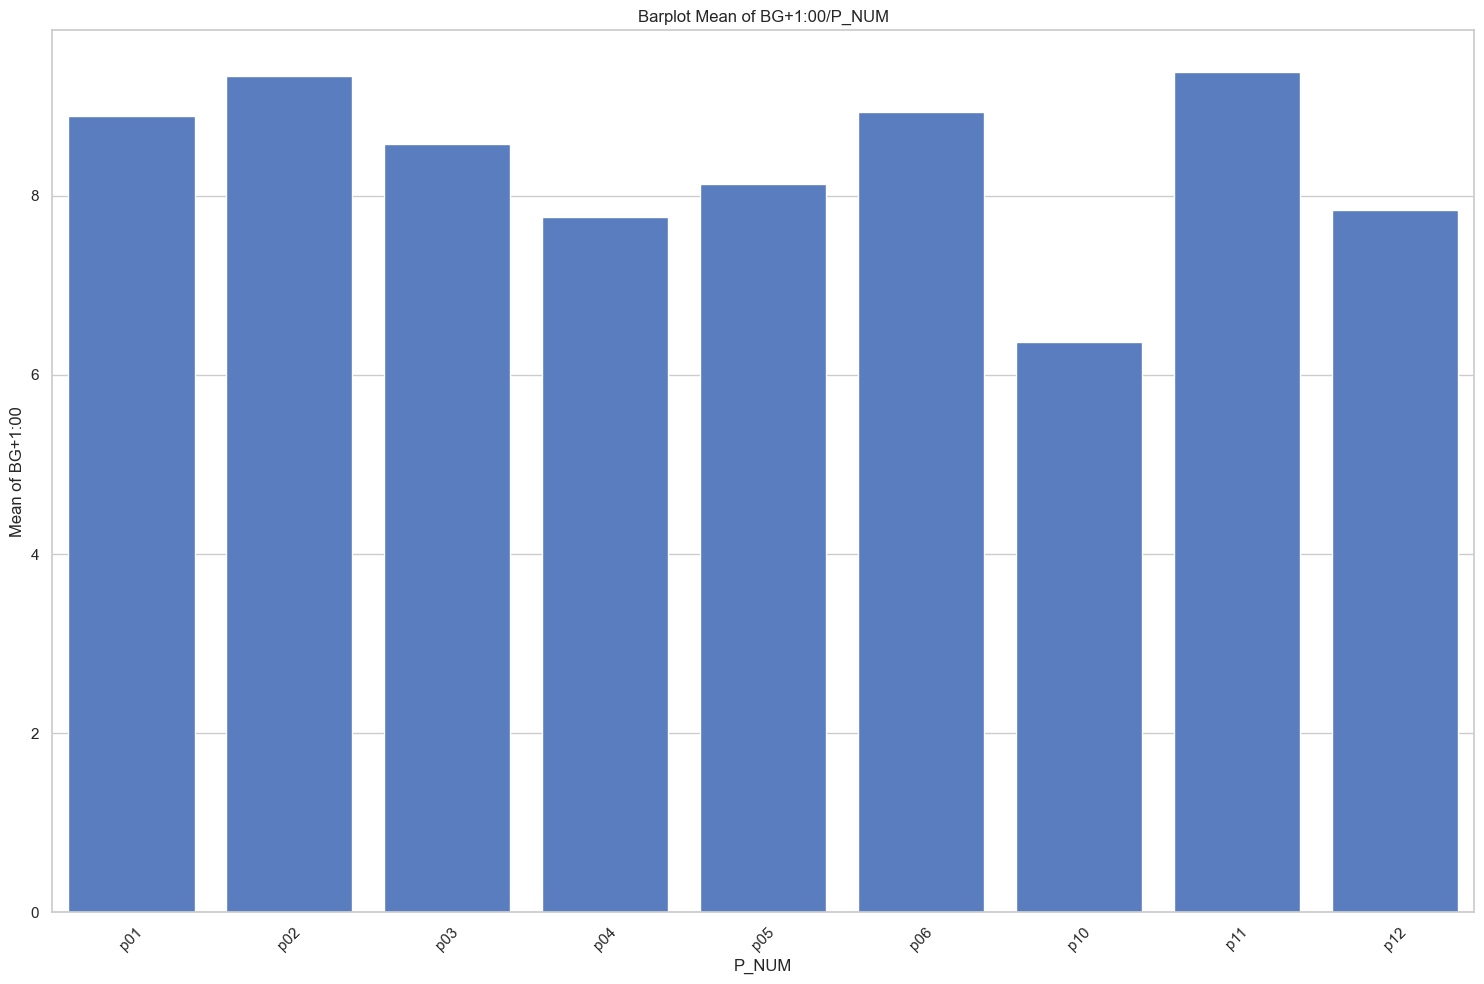

In [68]:
plt.figure(figsize=(15, 10))
sns.barplot(data=stats_pd, x="participant_id", y="mean")
plt.title("Barplot Mean of BG+1:00/P_NUM")
plt.xlabel("P_NUM")
plt.ylabel("Mean of BG+1:00")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Barplot: Interquartile Range (IQR) of BG+1:00/P_NUM

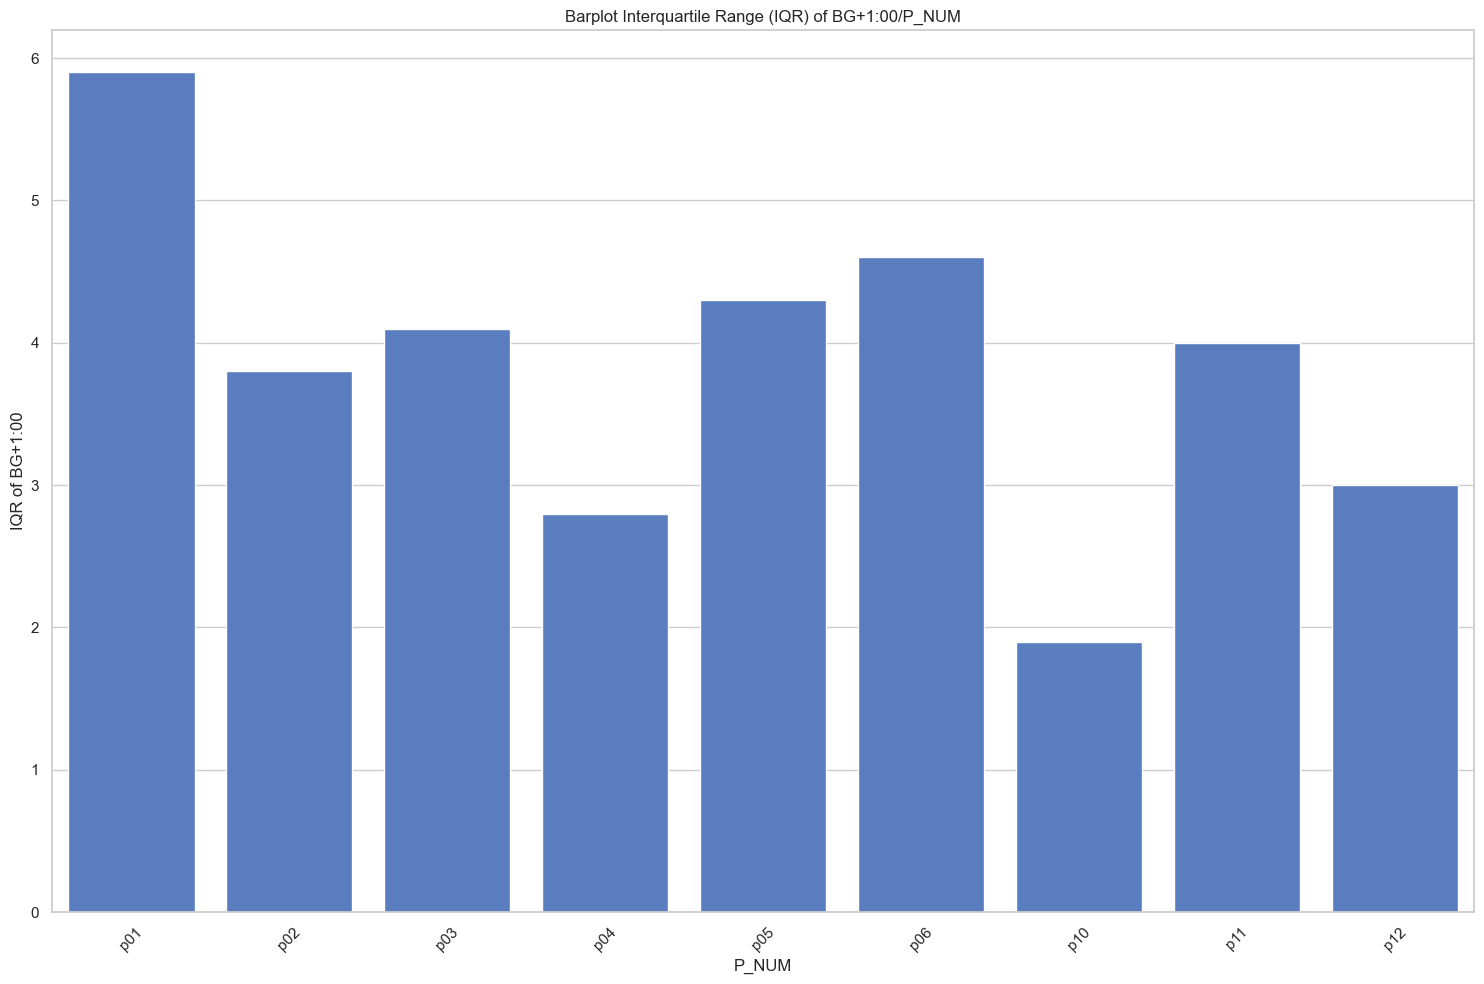

In [69]:
plt.figure(figsize=(15, 10))
sns.barplot(data=stats_pd, x="participant_id", y="IQR")
plt.title("Barplot Interquartile Range (IQR) of BG+1:00/P_NUM")
plt.xlabel("P_NUM")
plt.ylabel("IQR of BG+1:00")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Barplot: Standard Deviation (SD) of BG+1:00/P_NUM

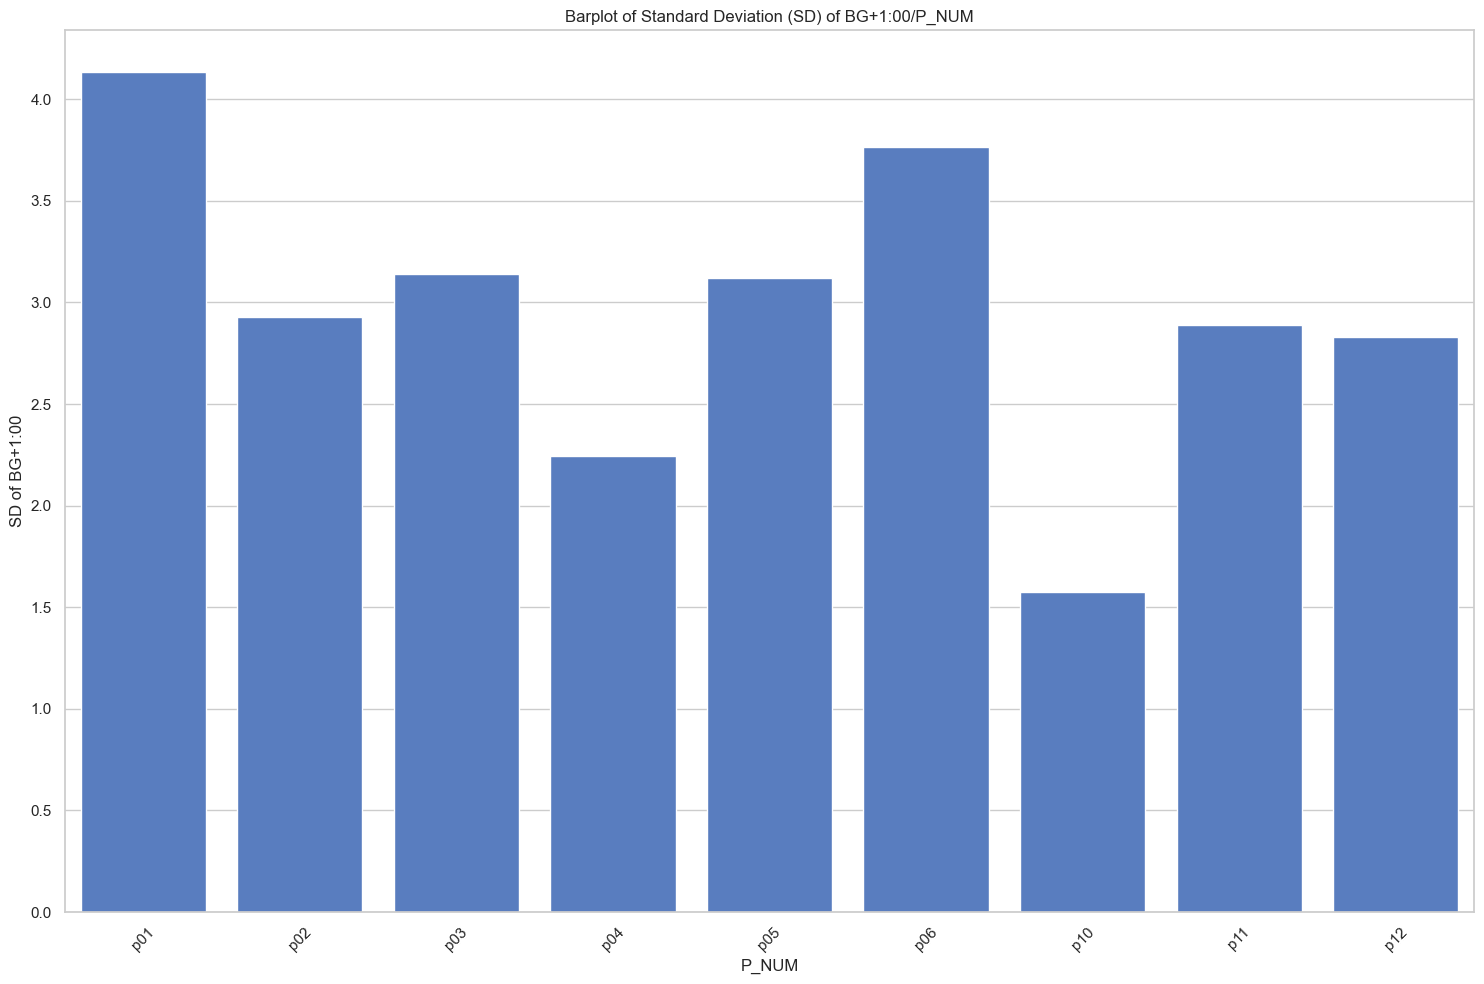

In [70]:
plt.figure(figsize=(15, 10))
sns.barplot(data=stats_pd, x="participant_id", y="std_dev")
plt.title("Barplot of Standard Deviation (SD) of BG+1:00/P_NUM")
plt.xlabel("P_NUM")
plt.ylabel("SD of BG+1:00")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Scatterplot: Skewness vs. Kurtosis of BG+1:00/P_NUM

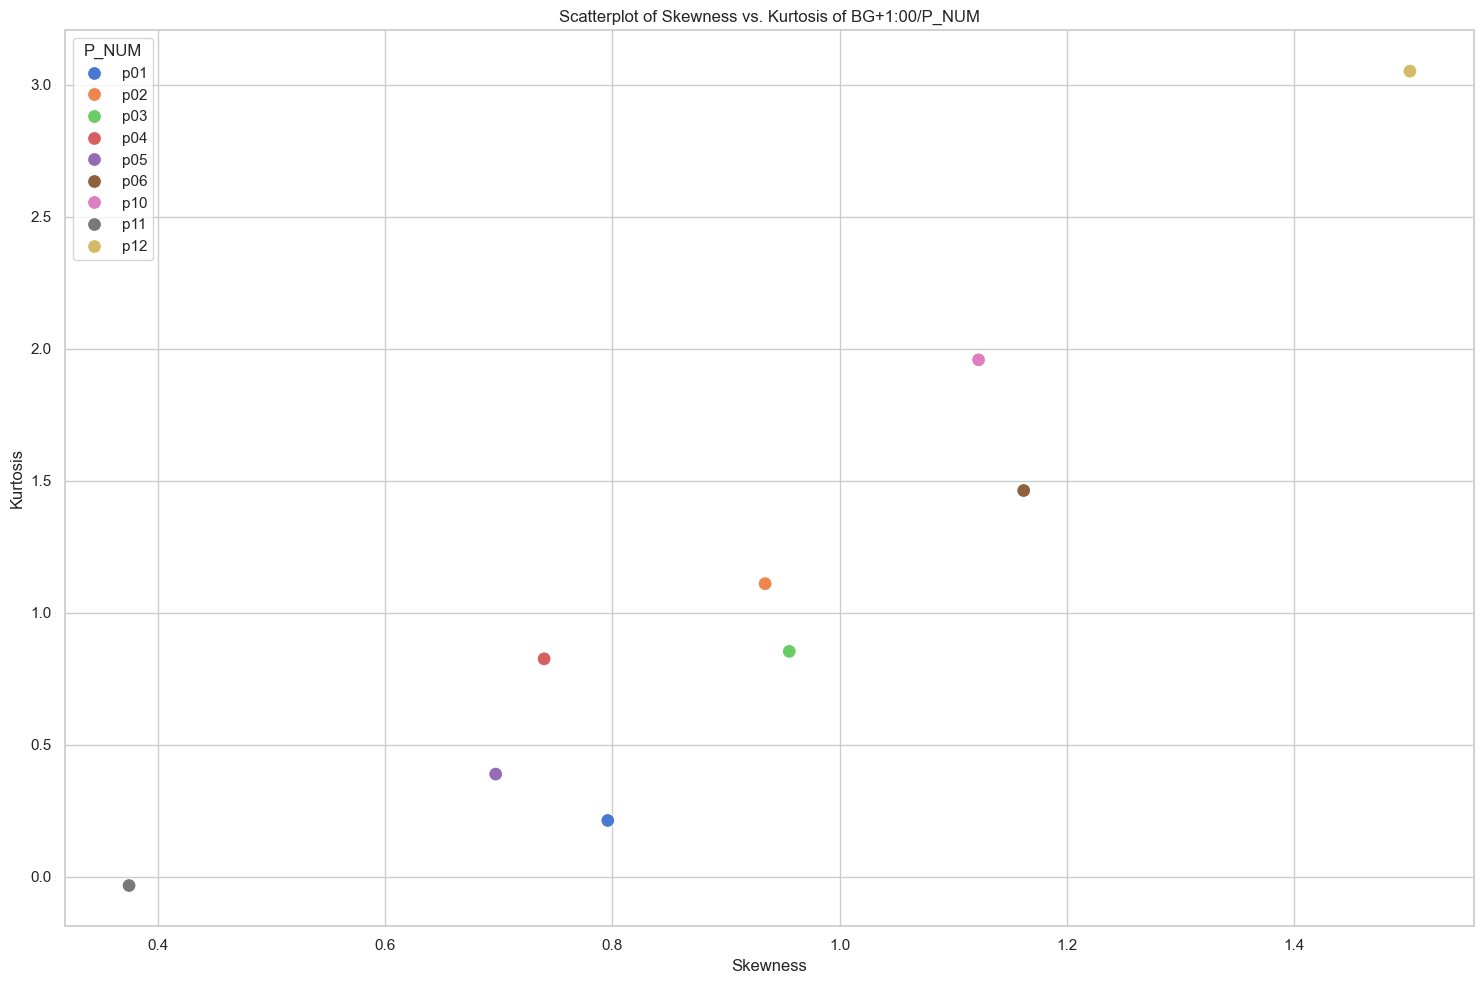

In [71]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=stats_pd, x="skewness", y="kurtosis", hue="participant_id", s=100)
plt.title("Scatterplot of Skewness vs. Kurtosis of BG+1:00/P_NUM")
plt.xlabel("Skewness")
plt.ylabel("Kurtosis")
plt.legend(title="P_NUM")
plt.tight_layout()
plt.show()

#### Boxplot: BG+1:00/P_NUM

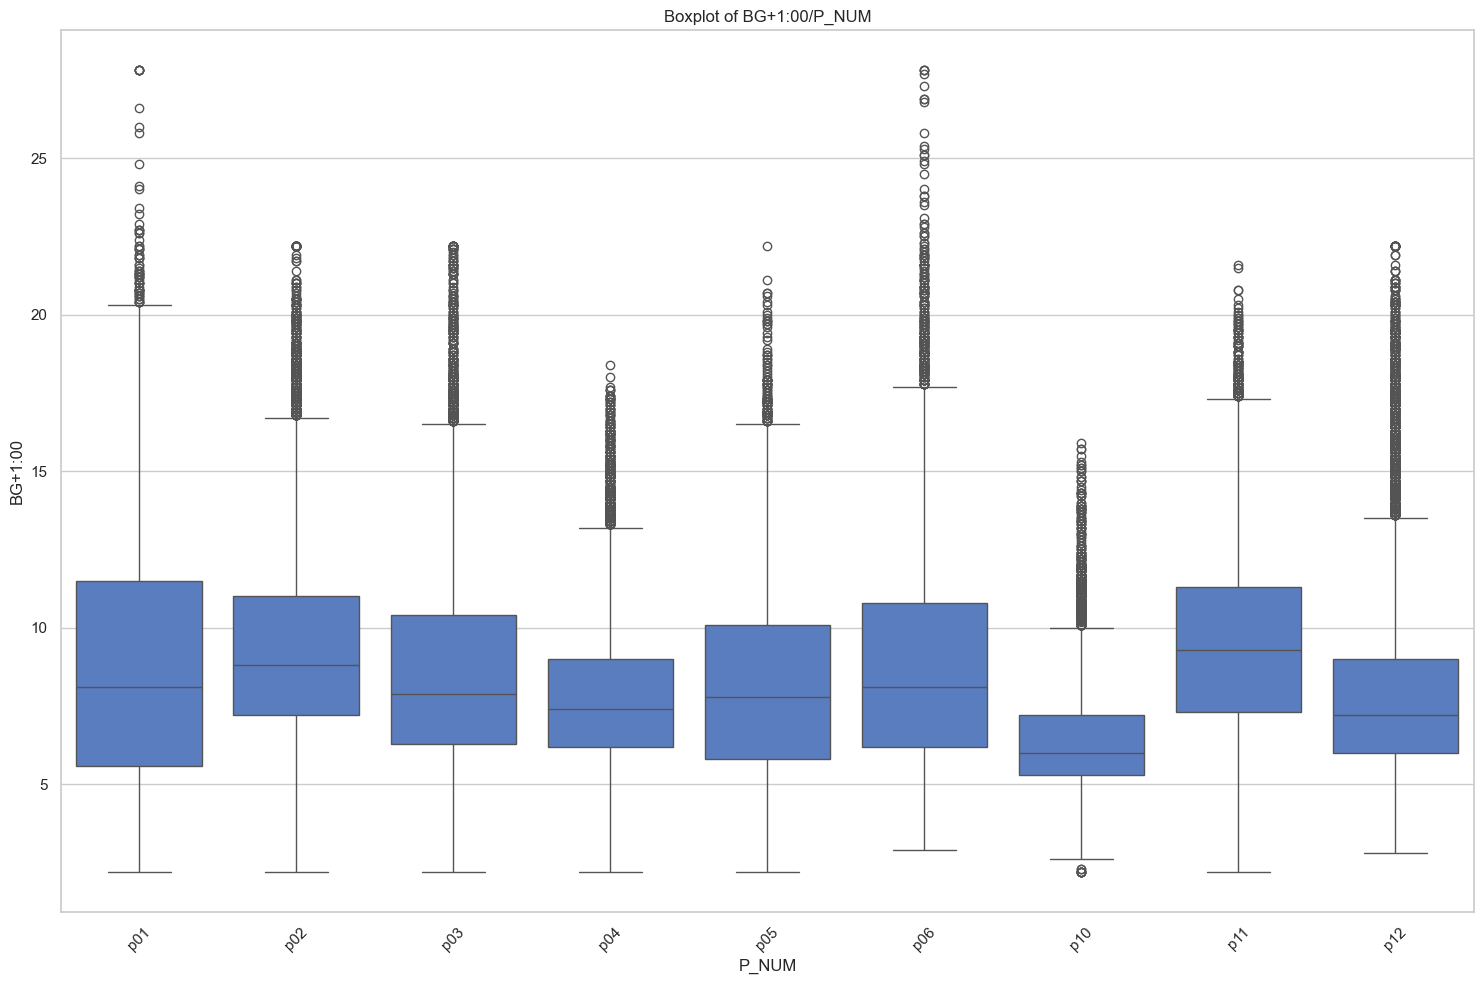

In [72]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_pd, x="participant_id", y="bg+1:00")
plt.title("Boxplot of BG+1:00/P_NUM")
plt.ylabel("BG+1:00")
plt.xlabel("P_NUM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Histogram: BG+1:00/P_NUM

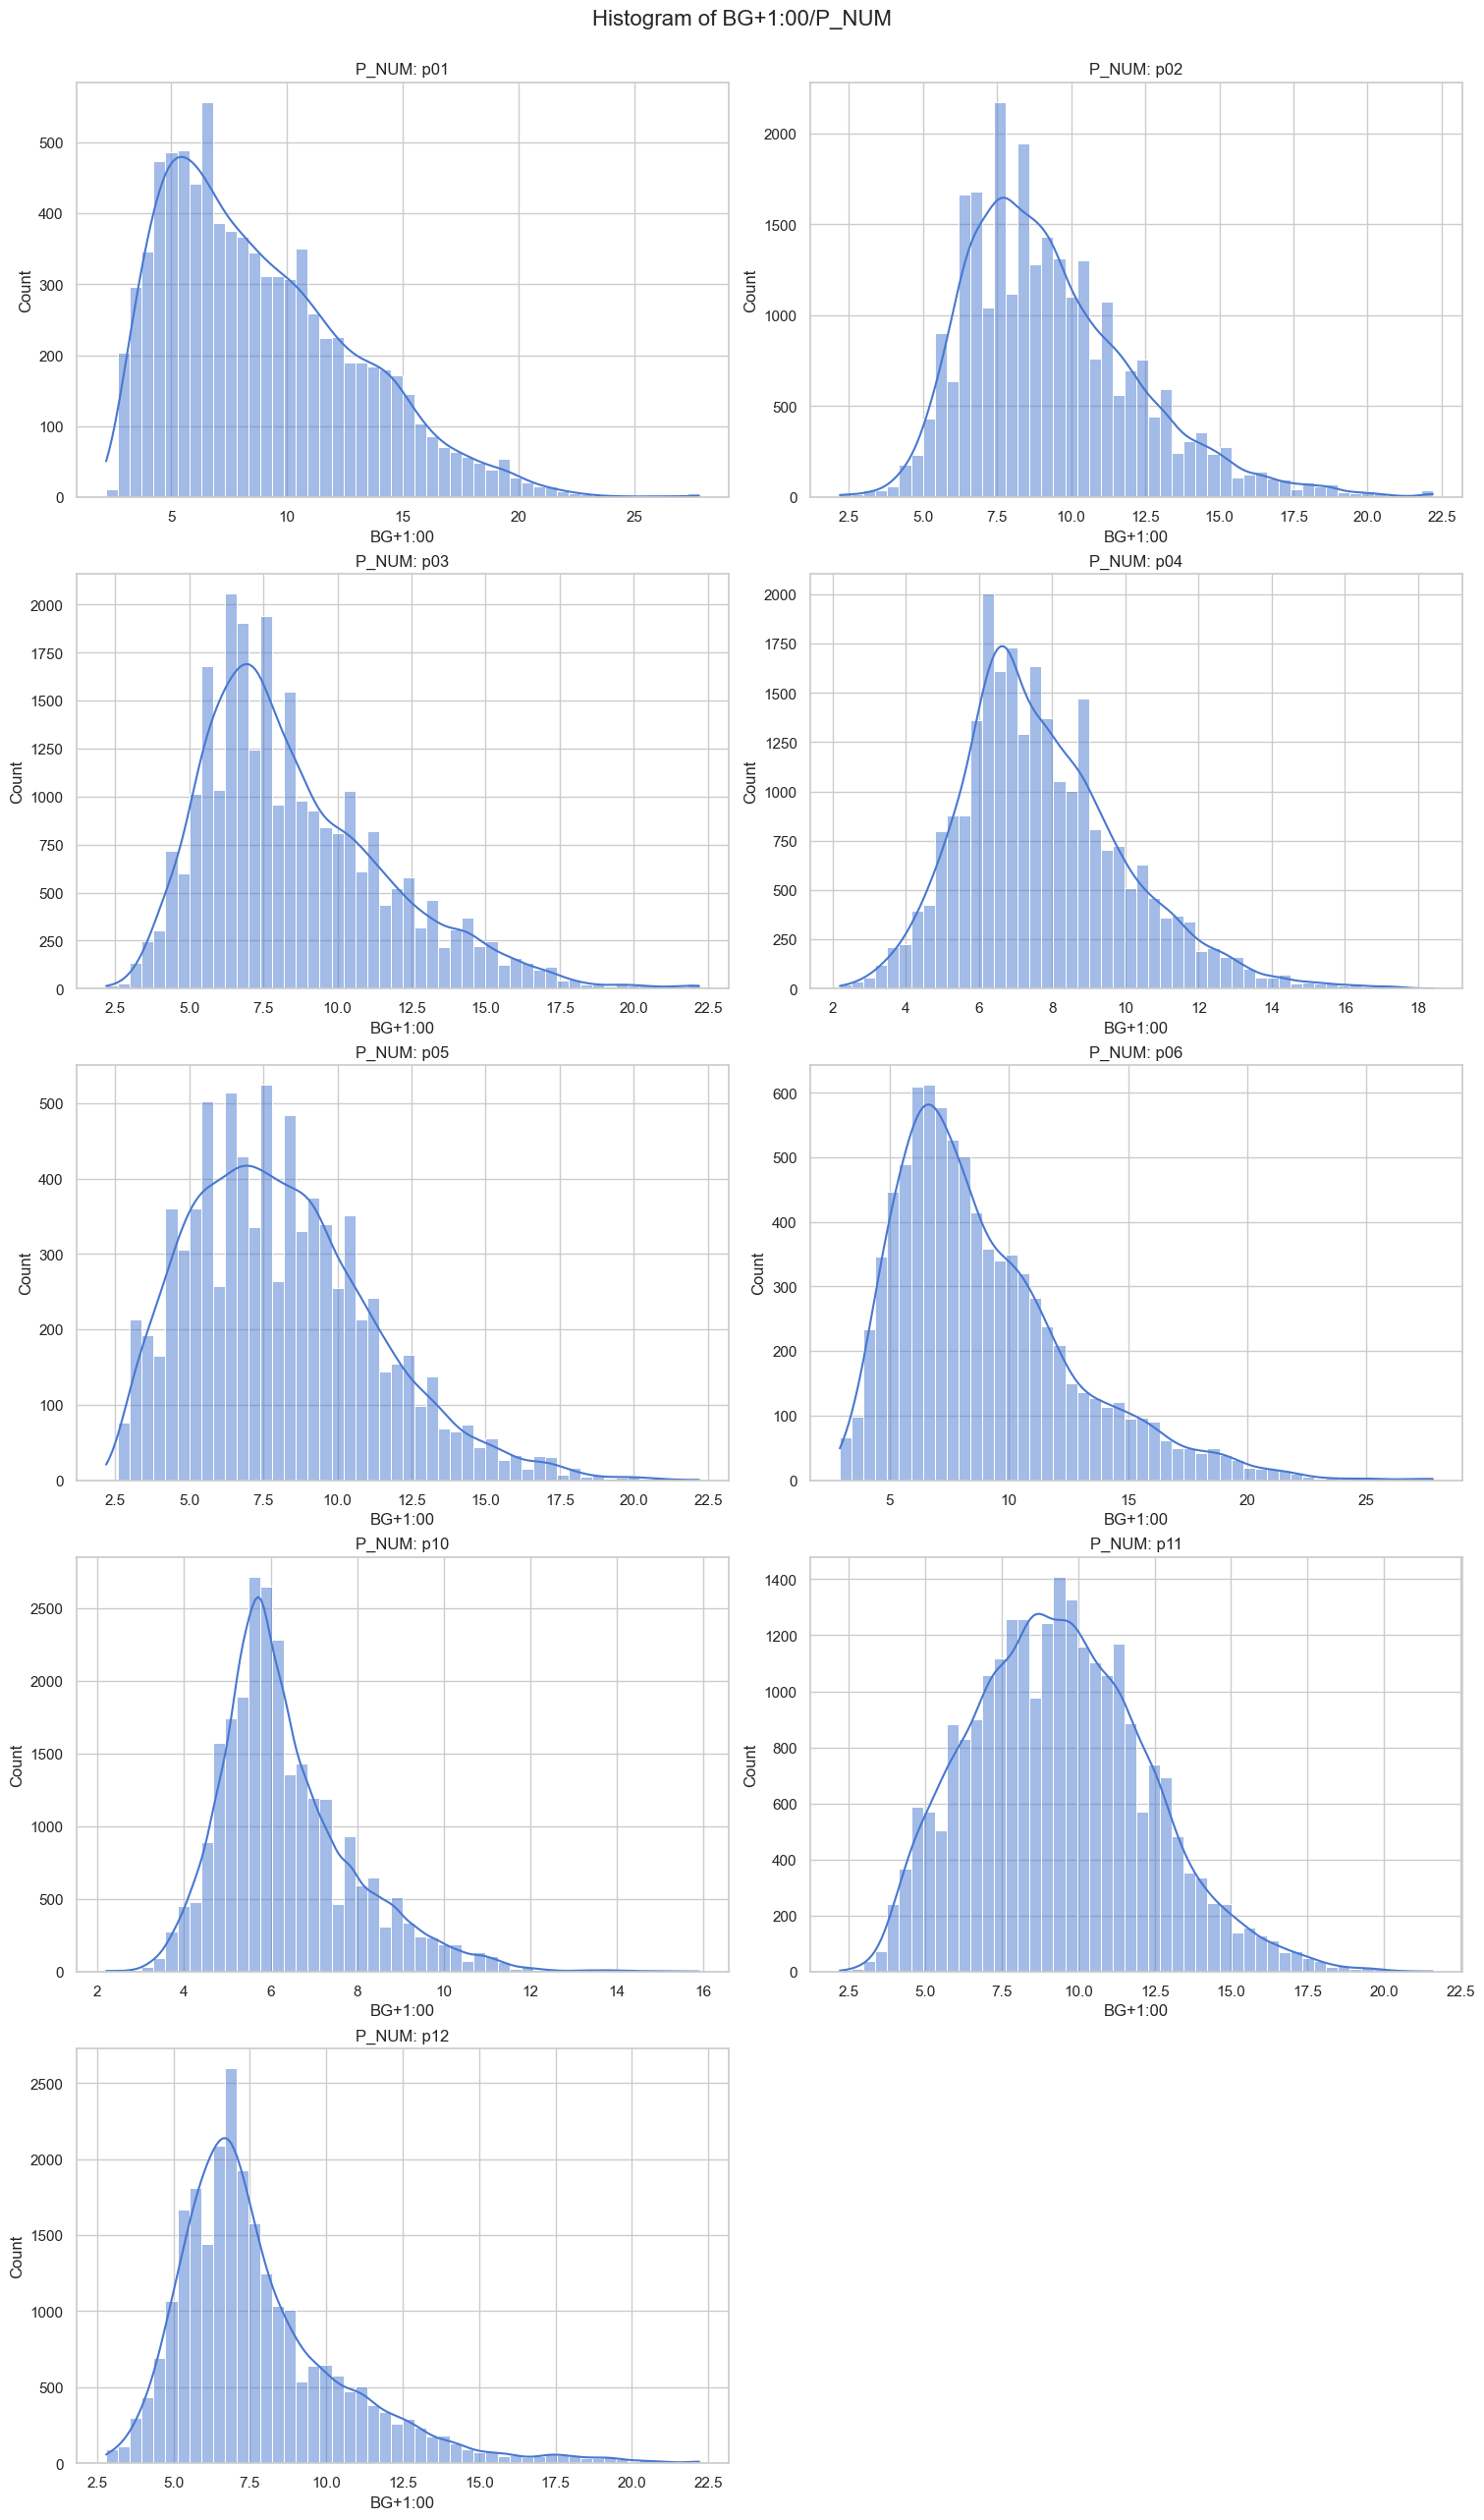

In [73]:
ncols = 2
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5), constrained_layout=True)

axes = axes.flatten()

for idx, pid in enumerate(participants):
    subset = train_pd[train_pd["participant_id"] == pid]
    ax = axes[idx]
    sns.histplot(subset["bg+1:00"], bins=50, kde=True, ax=ax)
    ax.set_title(f"P_NUM: {pid}")
    ax.set_xlabel("BG+1:00")
    ax.set_ylabel("Count")

for ax in axes[len(participants):]:
    ax.set_visible(False)

plt.suptitle("Histogram of BG+1:00/P_NUM", fontsize=16, y=1.02)
plt.show()

### Time-Series Analysis

In [ ]:
train_pd = train[["participant_id", "bg+1:00", "hour"]]
train_pd["hour"] = pd.to_numeric(train_pd["hour"], errors="coerce")

train_pd = train_pd.sort_values(by=["participant_id", "hour"])
train_pd["index"] = train_pd.groupby("participant_id").cumcount()

participants = sorted(train_pd["participant_id"].unique())

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27784\4058707259.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


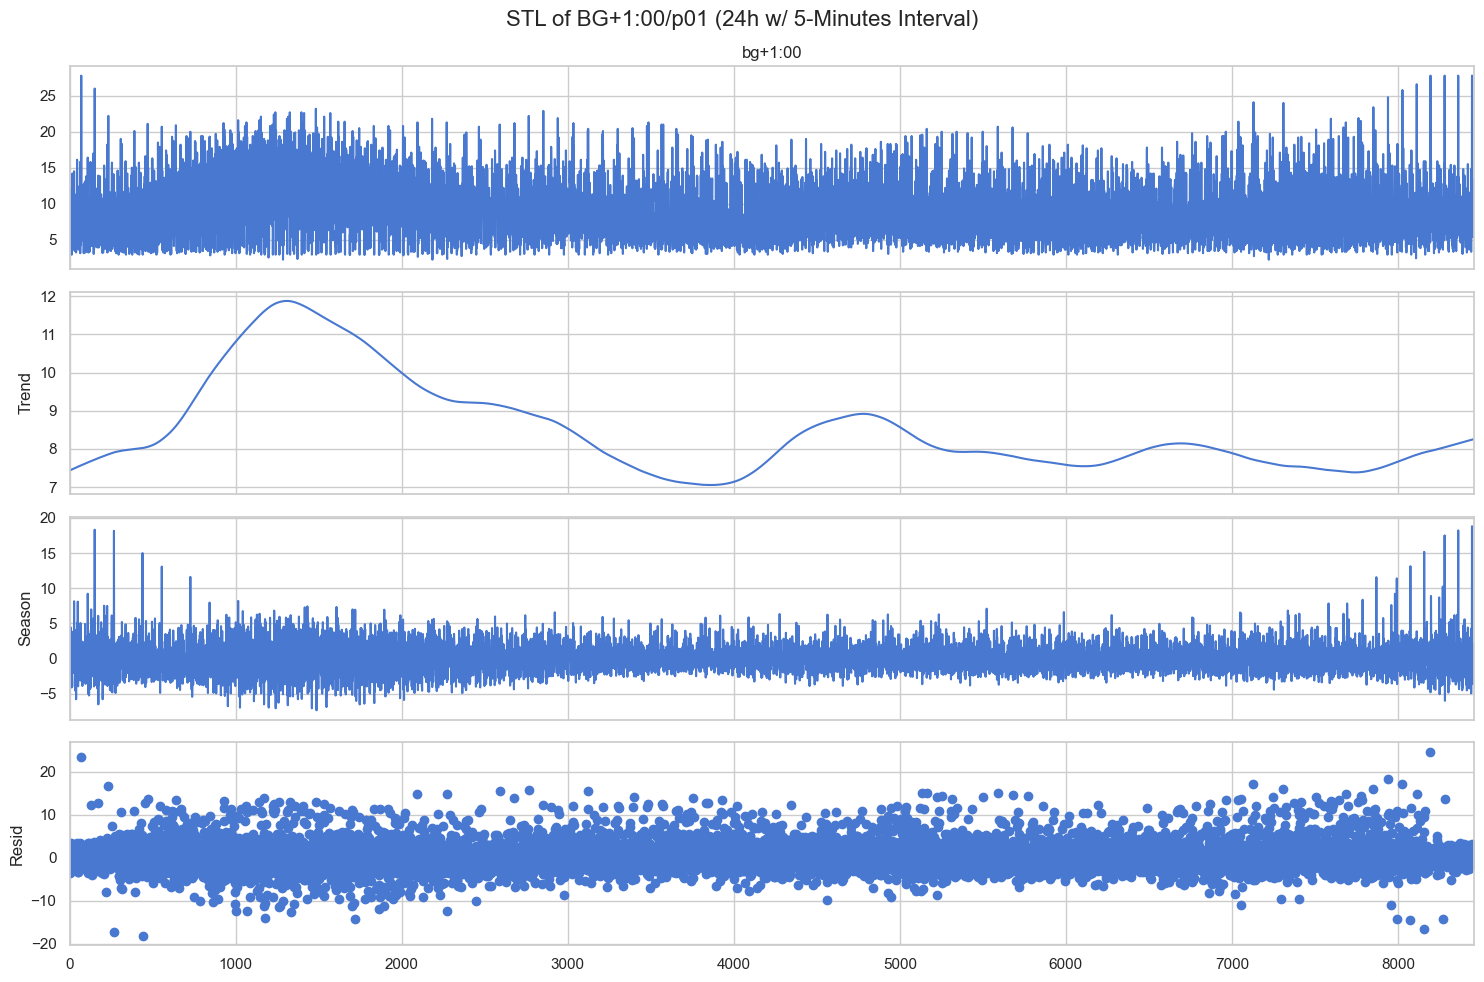

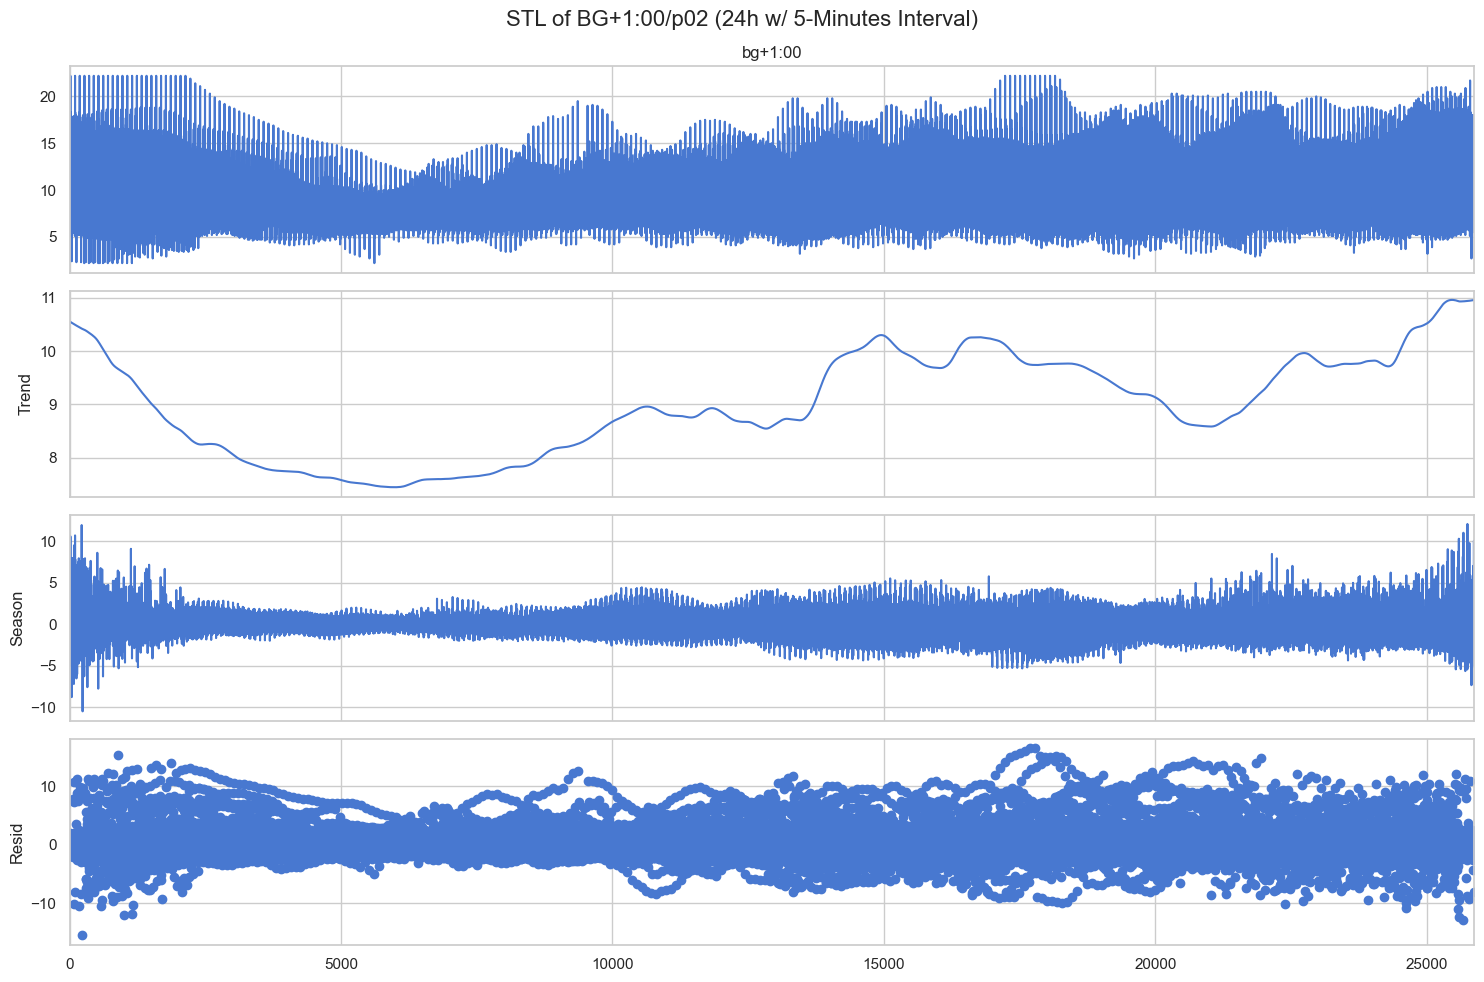

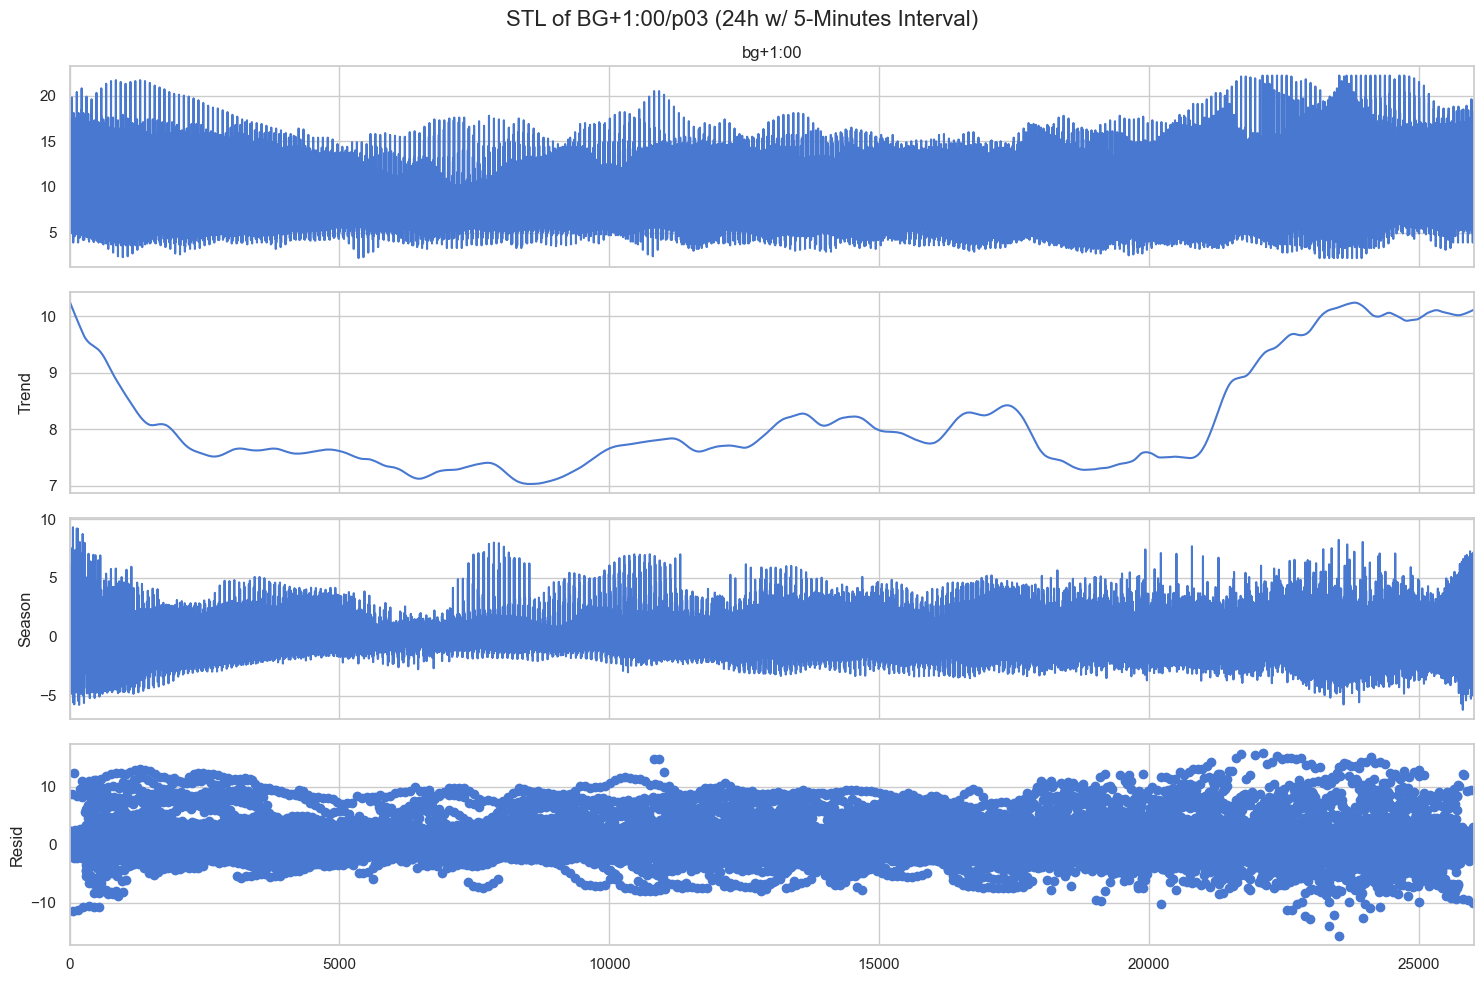

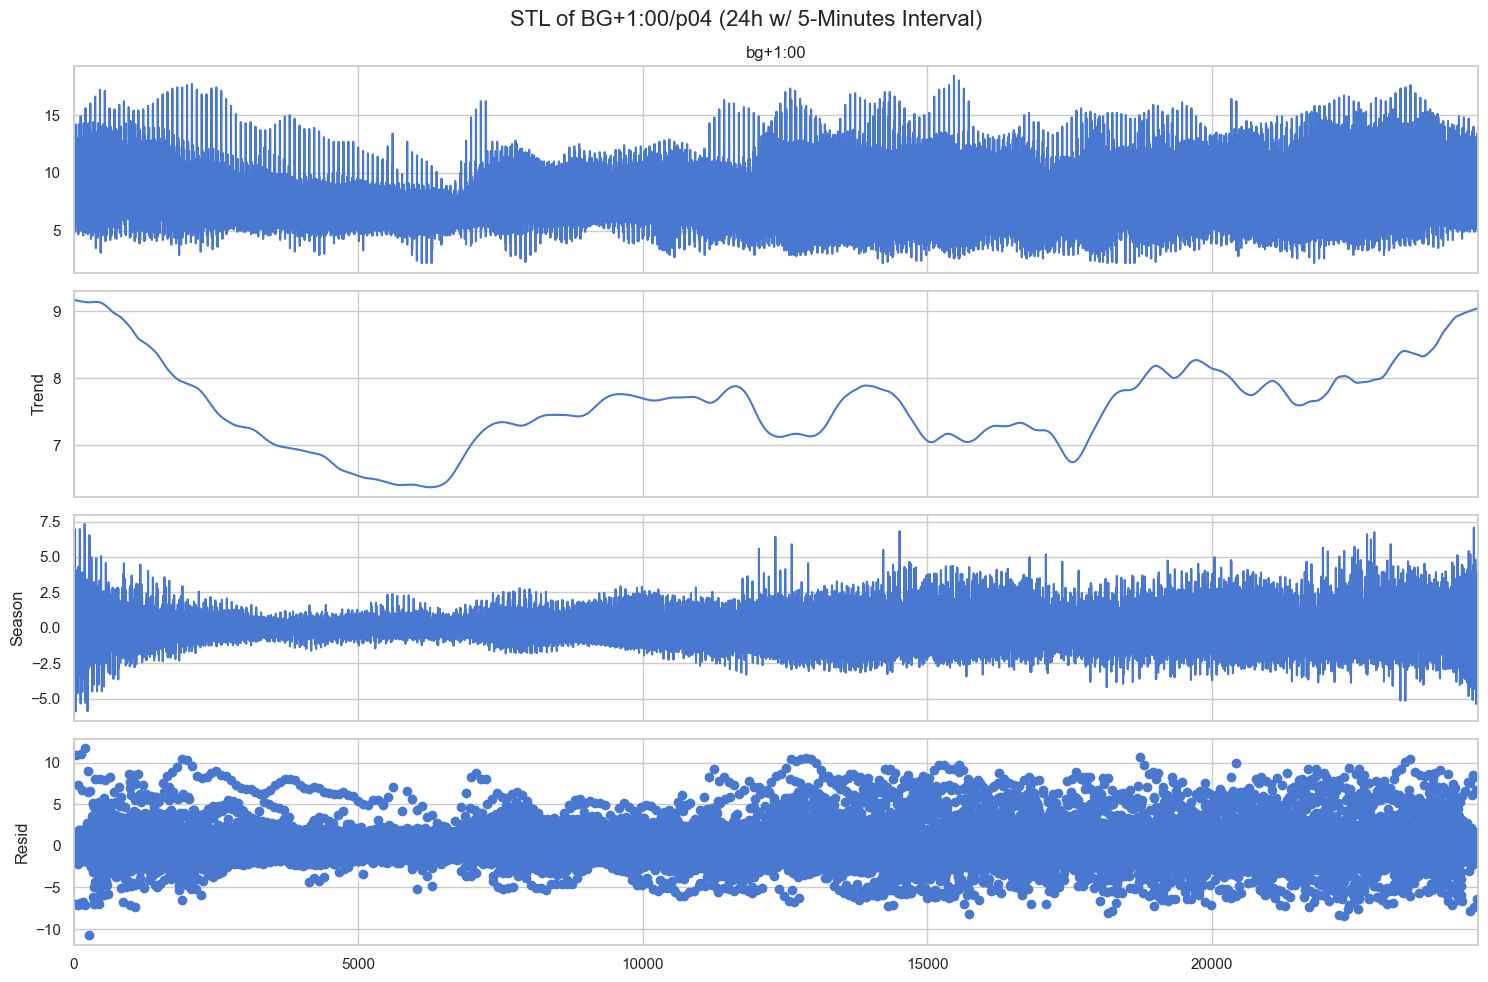

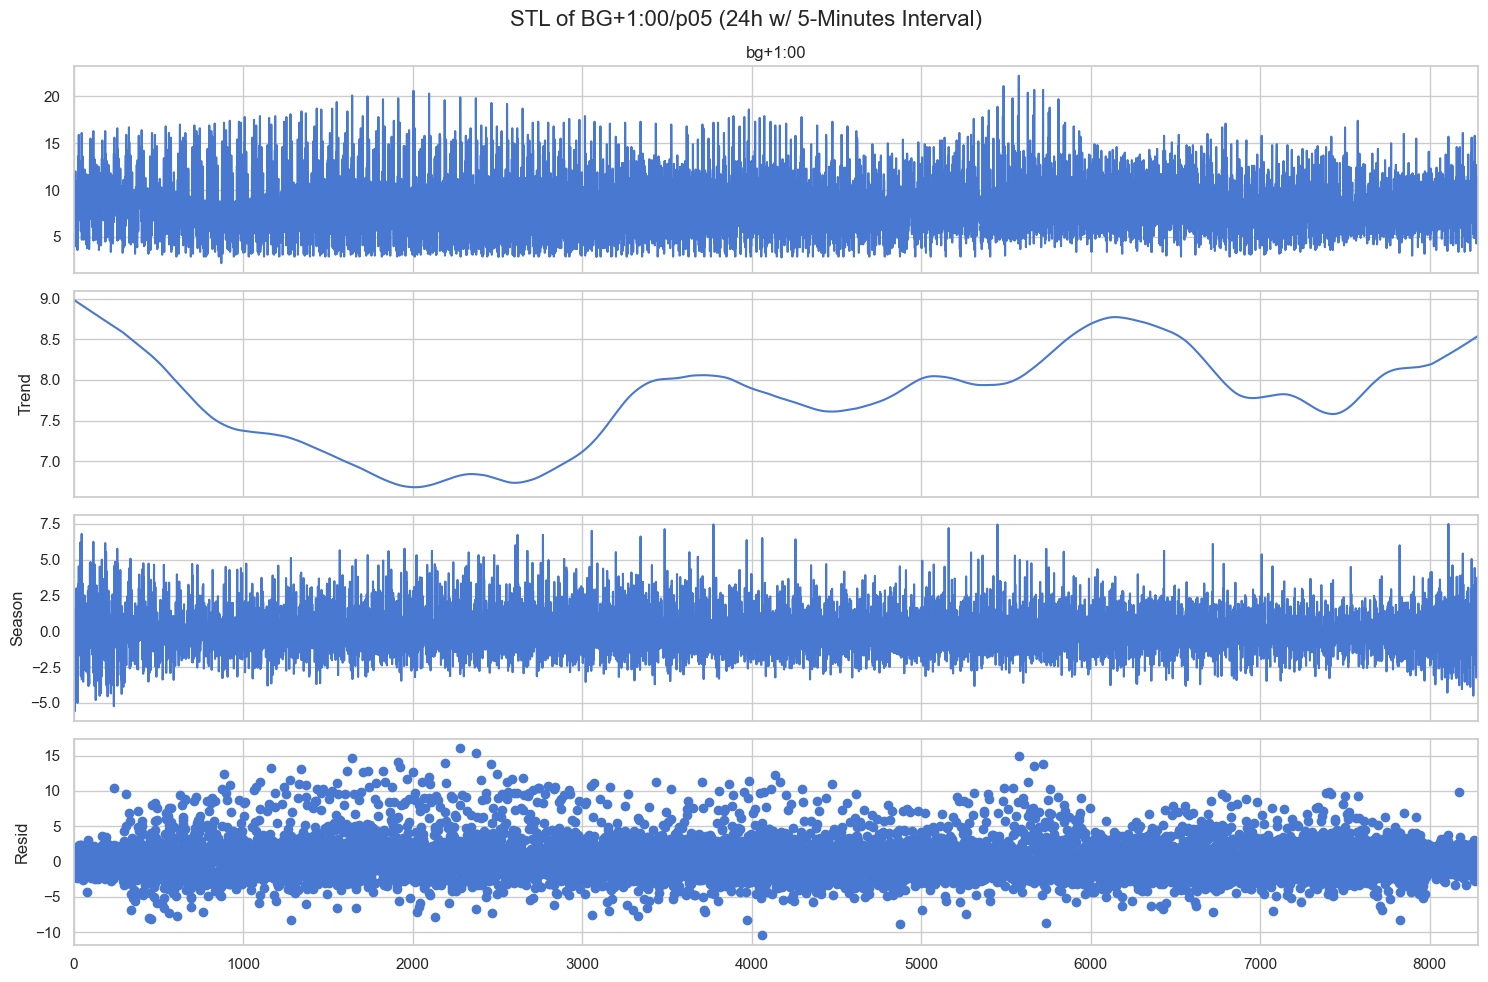

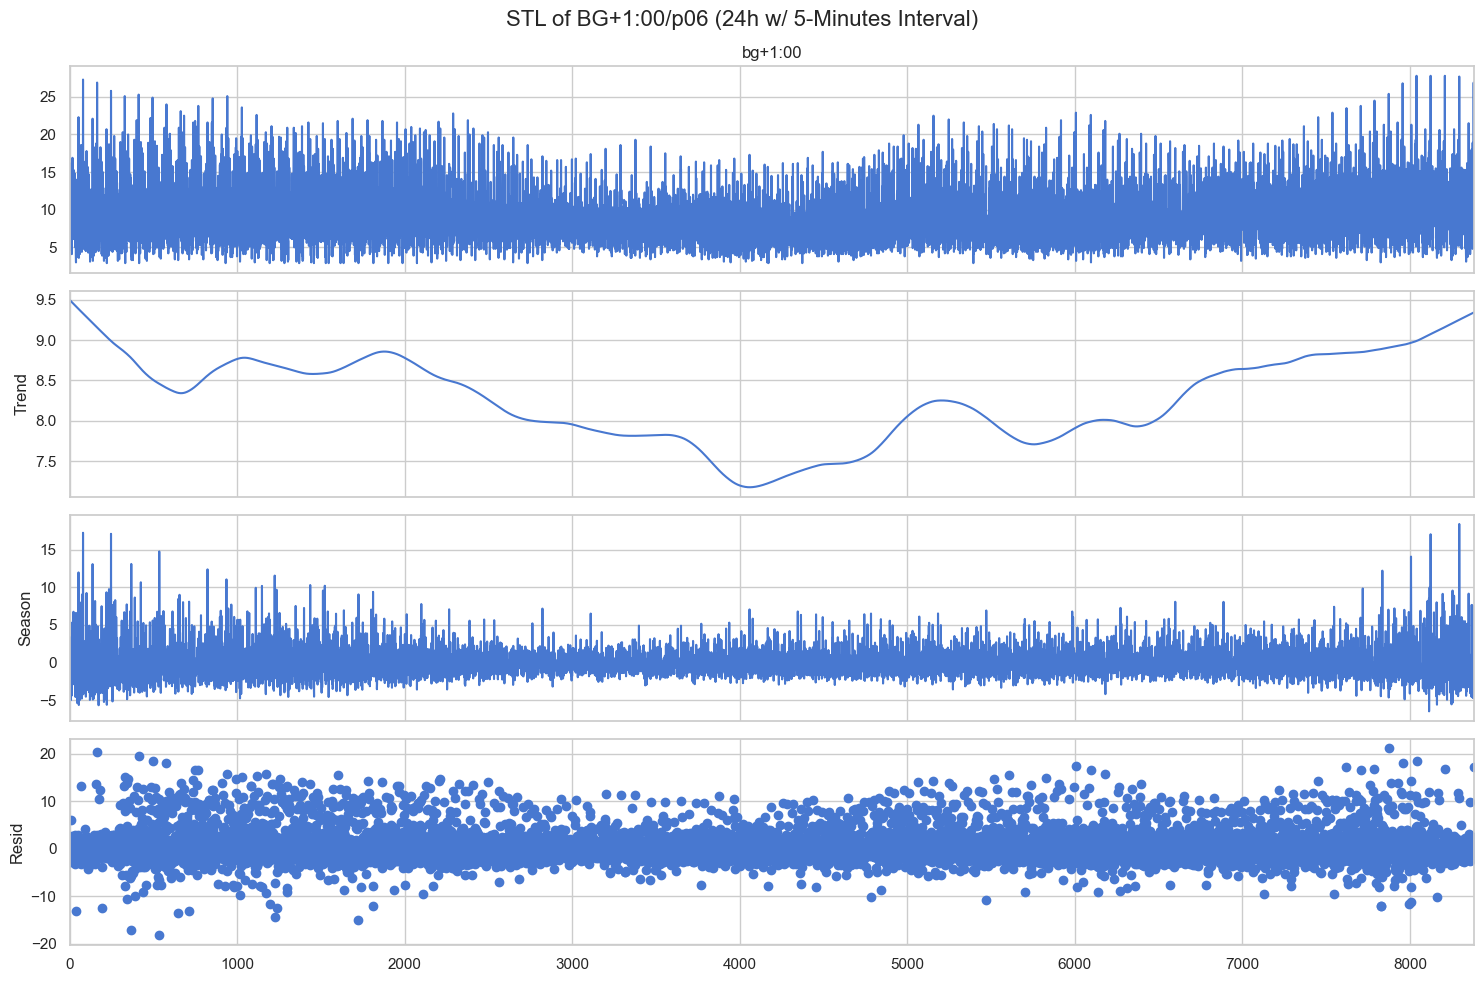

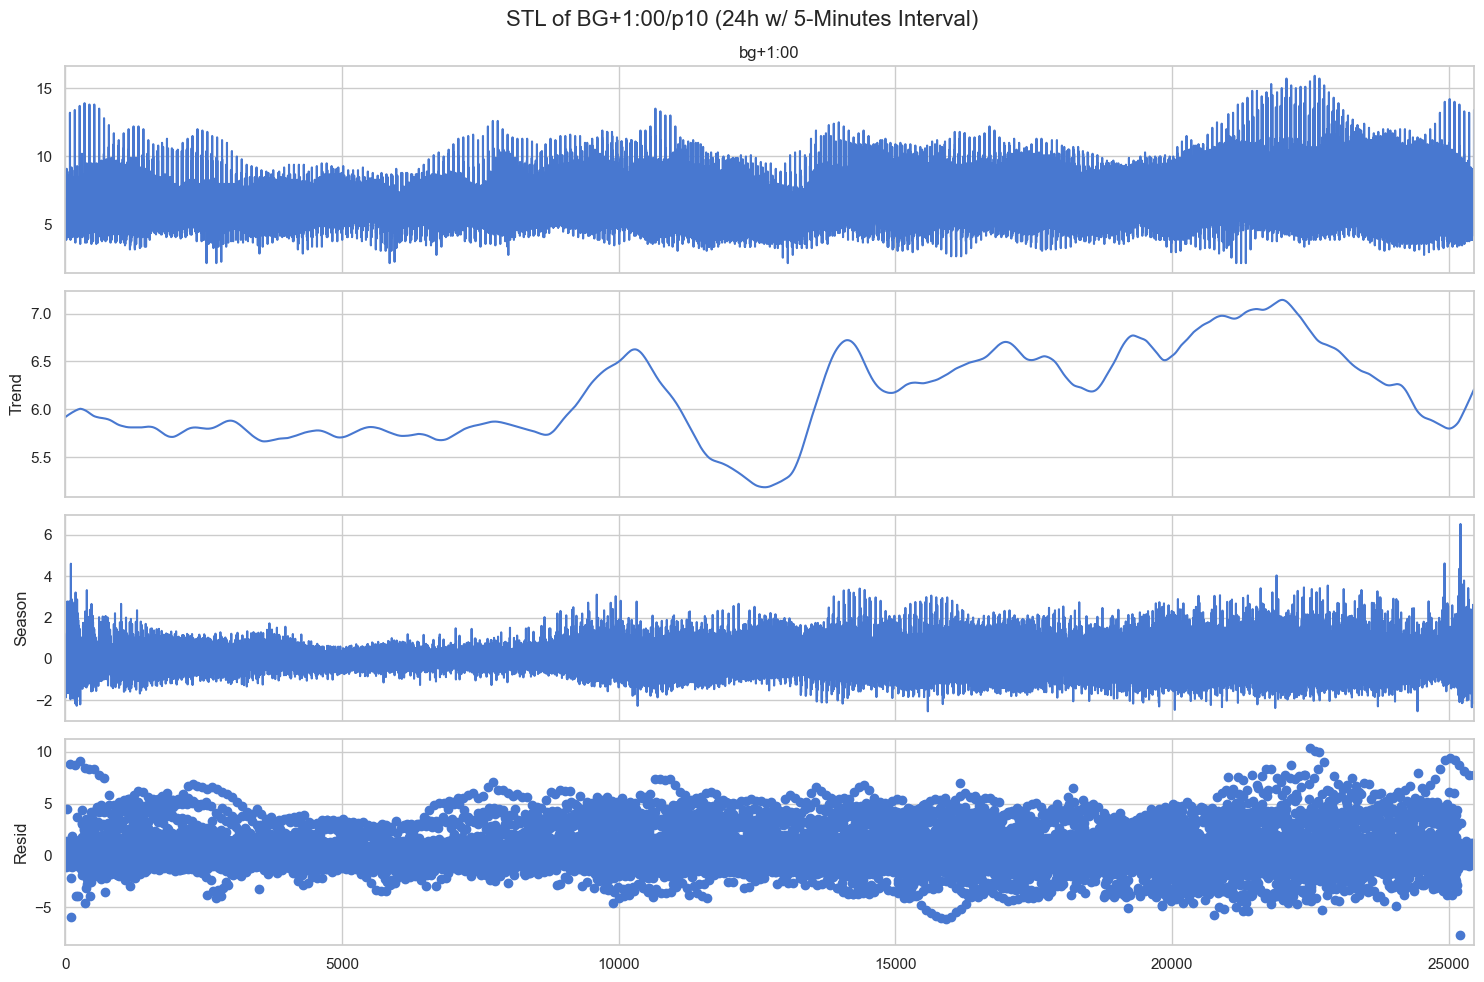

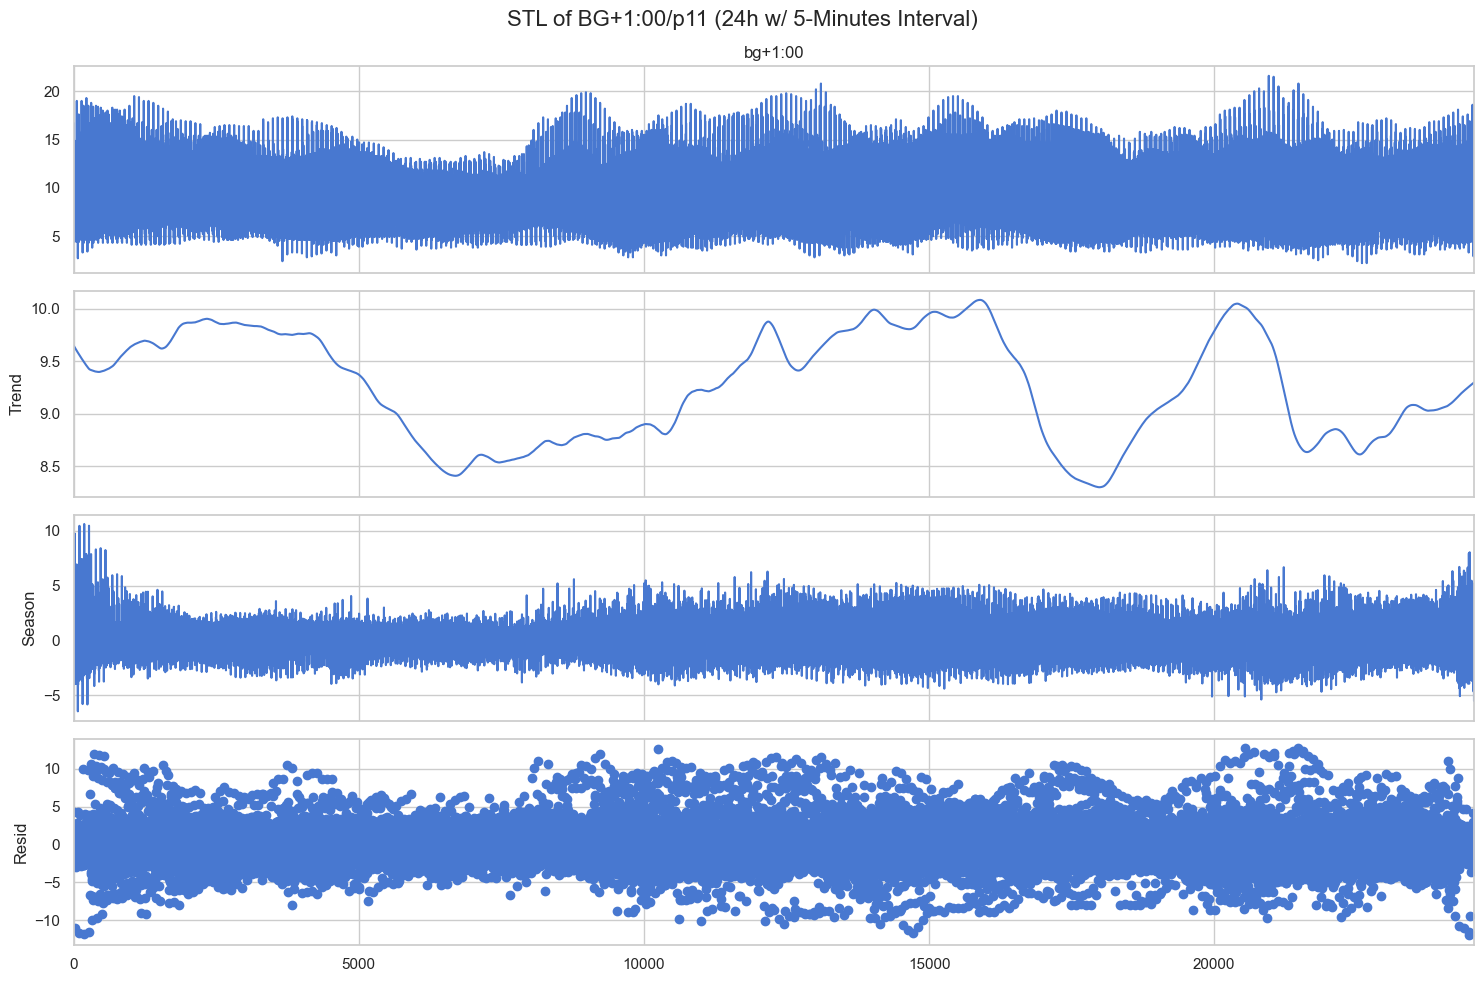

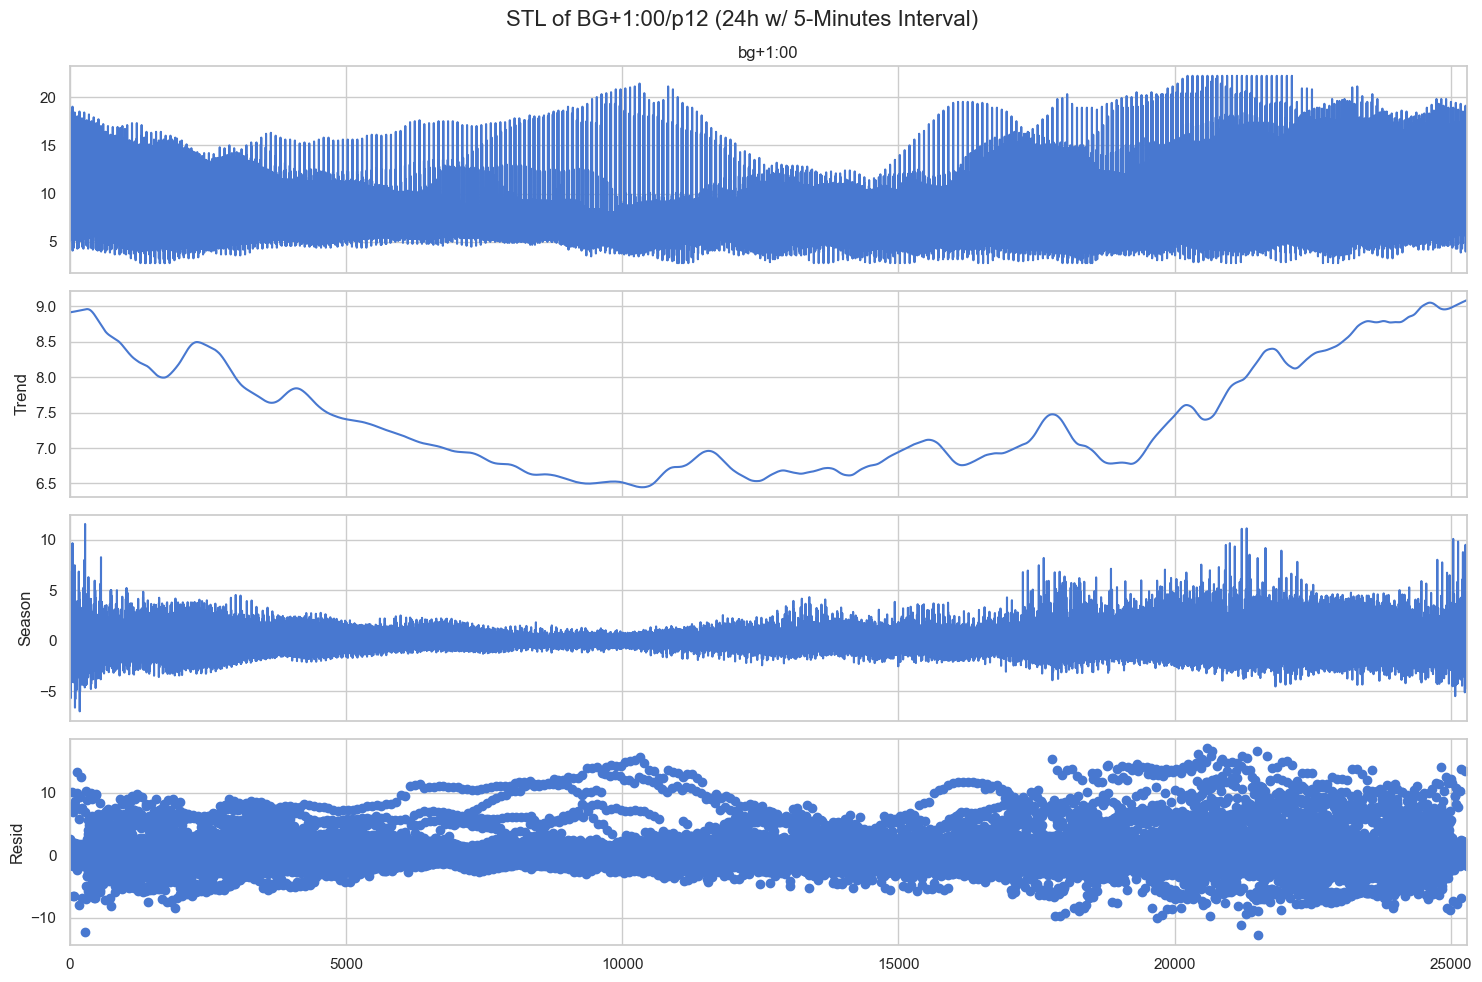

In [ ]:
for pid in participants:
    subset = train_pd[train_pd["participant_id"] == pid]
    subset = subset.set_index("index")
    series = subset["bg+1:00"]

    try:
        stl = STL(series, period=288, robust=True)
        result = stl.fit()

        fig = result.plot()
        fig.set_size_inches(15, 10)
        fig.suptitle(f'STL of BG+1:00/{pid} (24h w/ 5-Minutes Interval)', fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error {pid}: {e}")